<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 
    
    
____


### Full Name : Amirhossein Mahmoudi

### Student Number : 98108779

---


# Introduction


In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.


In [73]:
# Basic libraries
import numpy as np
import pandas as pd
from scipy import stats


# Statistics, EDA, metrics libraries
from scipy.stats import normaltest, skew
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


# Data Documentation


For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data.
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "\_mut" at the end of the names of the columns)
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).


# Data Preparation (15 Points)


In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)


## Data Loading & Splitting


In [19]:
# TODO
df = pd.read_csv('METABRIC_RNA_Mutation.csv', dtype={
                 'siah1_mut': 'str', 'smarcb1_mut': 'str', 'hras_mut': 'str', 'rasgef1b_mut': 'str'})
# dfx=df.loc[:,df.columns.tolist()[678]]
# dfx.head()
# siah1_mut
# smarcb1_mut
# hras_mut
# rasgef1b_mut
df.head()


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [67]:
clinical_data = df.loc[:, "patient_id":"death_from_cancer"]
clinical_data.head()


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [28]:
gene_data = df.drop(df.iloc[:, 1:31], axis=1)
gene_data.head()


,patient_id,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,0,0,0,0,0,0,0,0,0,0
1,2,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,0,0,0,0,0,0,0,0,0,0
2,5,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,...,0,0,0,0,0,0,0,0,0,0
3,6,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,...,0,0,0,0,0,0,0,0,0,0
4,8,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,...,0,0,0,0,0,0,0,0,0,0


In [59]:
desired_columns = pd.Series(gene_data.columns).str.endswith(
    "_mut").apply(lambda x: not x)
gene_exp_data = gene_data.loc[:, gene_data.columns[desired_columns]]
gene_exp_data.head()


,patient_id,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,2,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,5,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,...,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,6,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,...,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,8,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


In [60]:
desired_columns = pd.Series(gene_data.columns).str.endswith("_mut")
# make id columns value True
desired_columns[0] = True
gene_mut_data = gene_data.loc[:, gene_data.columns[desired_columns]]
gene_mut_data.head()


,patient_id,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,H178P,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,H1047R,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,E542K,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,S241F,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA


For each dataset, you must perform a sufficient EDA.(not mutated dataset)


#clinical data EDA


Text(0.5, 1.0, 'Missing value')

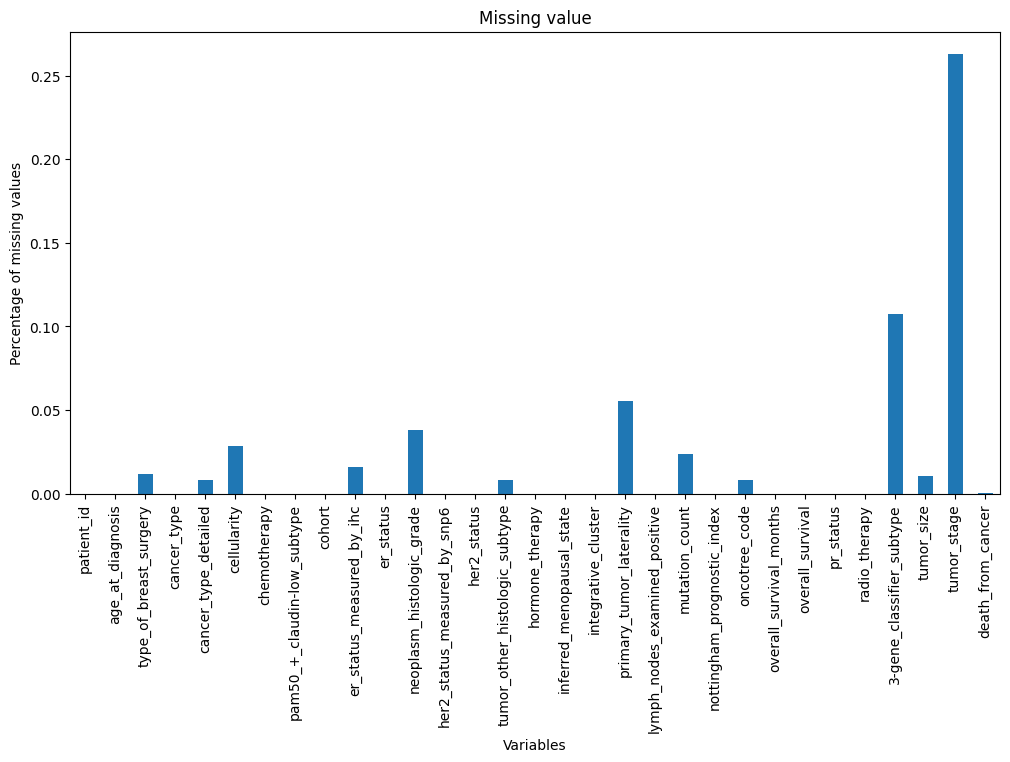

In [63]:
# Plot of missing value percentage
clinical_data.isnull().mean().plot.bar(figsize=(12, 6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Missing value')


Box plot of numerical data


In [79]:
# return numerical dataframe
def numerical_df(df):
    # drop non numerical columns
    num_df = df[df.select_dtypes(include=np.number).columns.tolist()]

    return num_df

# function that takes a dataframe and transforms it into a standard form after dropping non numirical columns


def numerical_standardizer(df):
    # drop non numerical columns
    num_df = numerical_df(df)
    # making standard scalar:removing mean and scale to variance 1
    standard_scalar = StandardScaler()
    # apply
    std = standard_scalar.fit_transform(num_df)
    # making new  dataframe
    standard_df = pd.DataFrame(std, index=num_df.index, columns=num_df.columns)
    return standard_df


std_clinical_data = numerical_standardizer(clinical_data)
std_clinical_data.head()


,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
0,-1.663366,1.122359,-0.512445,-1.338368,0.897956,0.788547,1.960788,NaN,1.757557,0.201518,1.173469,0.821330,-0.279656,0.396748
1,-1.662518,-1.379317,-0.512445,-1.338368,0.897956,0.788547,-0.490841,-0.911280,-0.011378,-0.530544,1.173469,0.821330,-1.071371,-1.193646
2,-1.661245,-0.941562,1.951430,-1.338368,-0.639479,0.788547,-0.245678,-0.911280,-0.002638,0.505525,-0.852174,-1.217538,-0.741490,0.396748
3,-1.660821,-1.033275,1.951430,-1.338368,-0.639479,0.788547,0.244648,-1.157725,0.014841,0.521686,1.173469,0.821330,-0.081727,0.396748
4,-1.659973,1.224091,1.951430,-1.338368,0.897956,0.788547,1.470462,-0.911280,1.789021,-1.097499,-0.852174,0.821330,0.907918,0.396748


Text(0, 0.5, 'Variables')

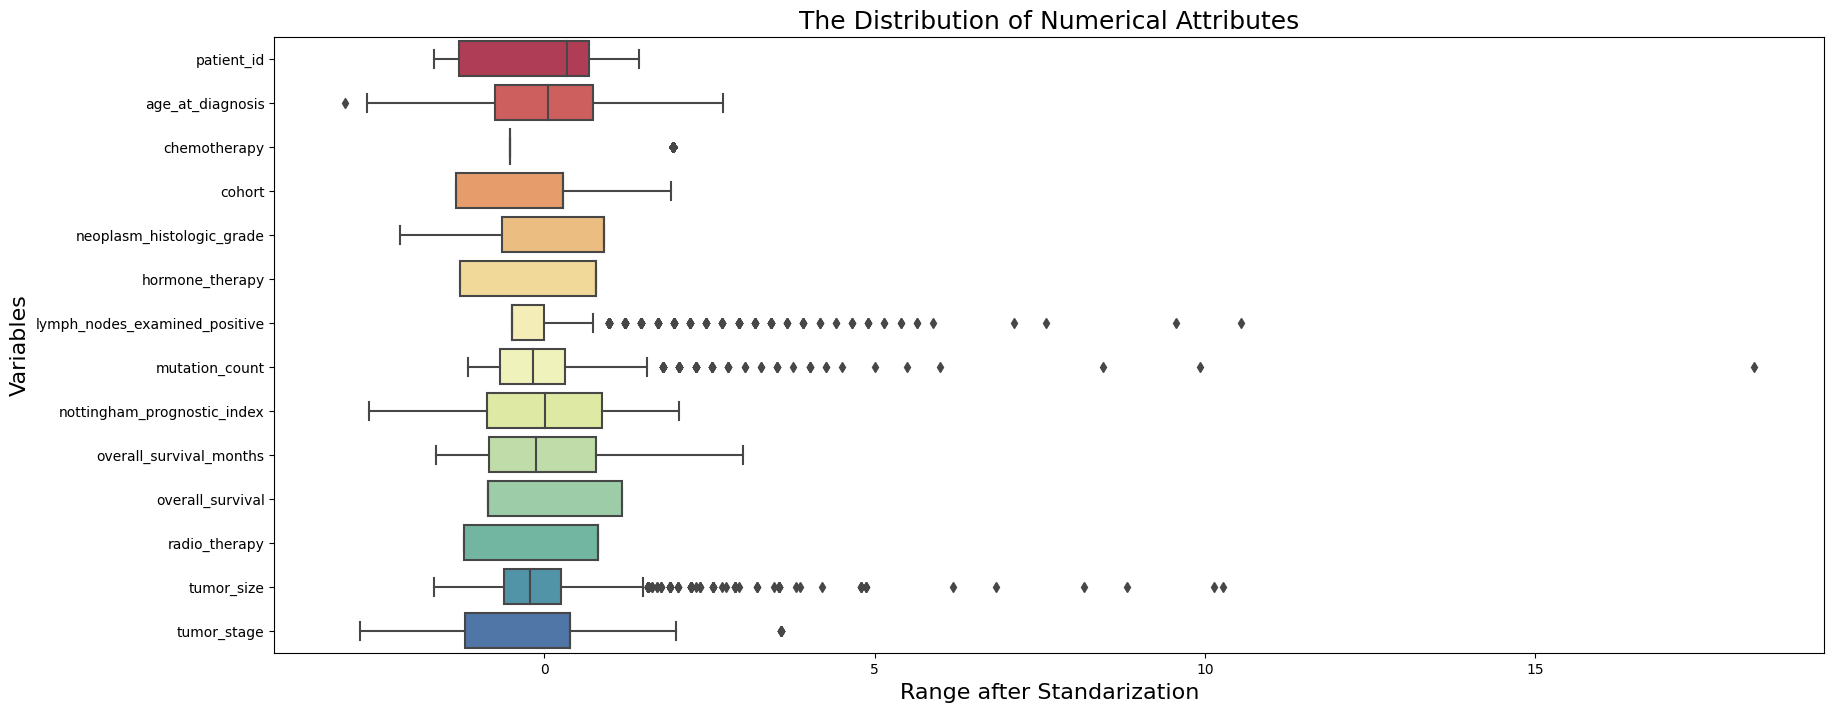

In [76]:
# Plot the boxplots of numerical variables
ax, fig = plt.subplots(1, 1, figsize=(20, 8))
plt.title('The Distribution of Numerical Attributes', fontsize=18)

sns.boxplot(y="variable", x="value", data=pd.melt(
    numerical_standardizer(clinical_data)), palette='Spectral')
plt.xlabel('Range after Standarization', size=16)
plt.ylabel('Variables', size=16)


target classes plots


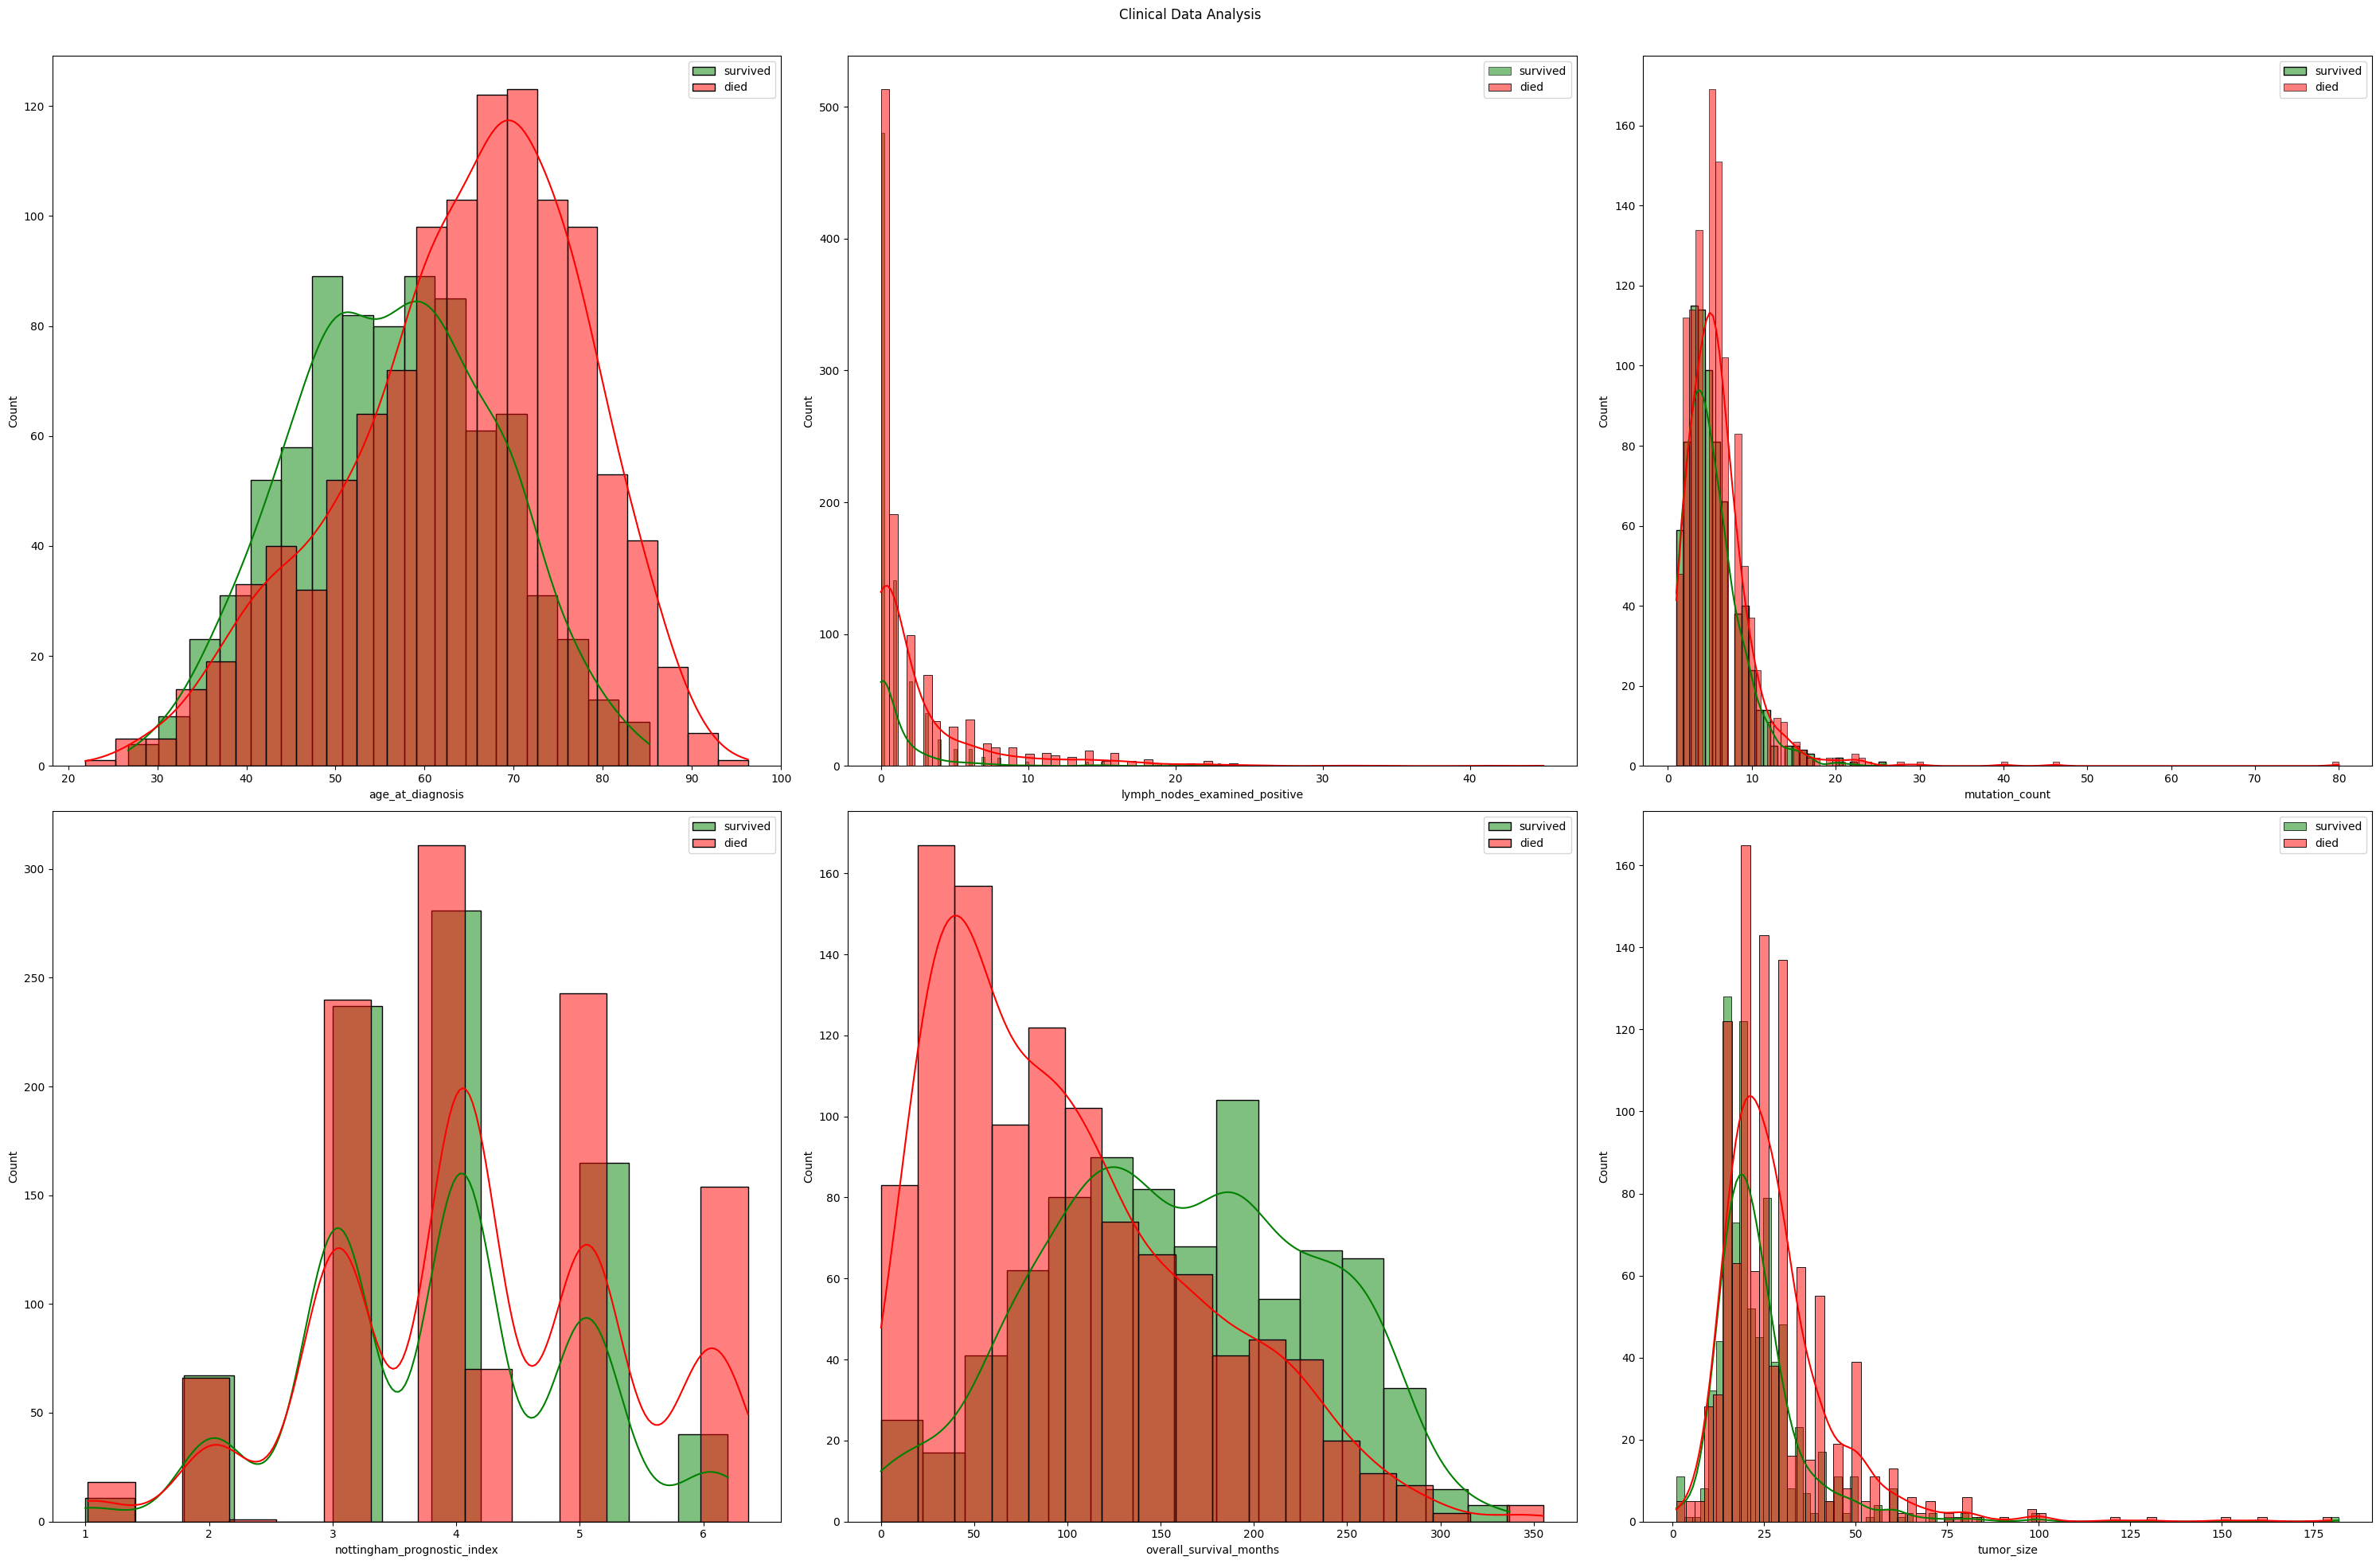

In [95]:
fig = plt.figure(figsize=(30, 20))
column_counter = 0
# num_clinical_columns= ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count',
#     'nottingham_prognostic_index', 'overall_survival_months', 'tumor_size' ]
important_numerical_clinical_data = numerical_df(clinical_data).drop(
    columns=['patient_id', 'chemotherapy', 'overall_survival', 'hormone_therapy', 'radio_therapy', 'neoplasm_histologic_grade', 'cohort', 'tumor_stage'])
for i in important_numerical_clinical_data:
    plt.subplot(2, 3, column_counter+1)
    column_counter += 1
    sns.histplot(clinical_data[i][clinical_data['overall_survival']
                 == 1], color='g', label='survived', kde=True)
    sns.histplot(clinical_data[i][clinical_data['overall_survival']
                 == 0], color='r', label='died', kde=True)
    plt.legend(loc='best')
fig.suptitle('Clinical Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()


Age at diagonosis:
The patients who survived have bimodal distribution
The patients who died have left skewed distribution

Lymph nodes examined positive :
both the patients who survived and died have right skewed distribution

Mutation count :
both the patients who survived and died have right skewed distribution

Nottingham prognostic index :
both the patients who survived and died have multimodal distribution

Overall survival months:
The patients who survived have bimodal distribution
The patients who died have right skewed distribution

Tumor size :
both the patients who survived and died have right skewed distribution


## Dimension Reduction (20 + Up to 10 Points Optional)


For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.


In [ ]:
# TODO


# Classic Model (25 Points)


In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)


In [ ]:
# TODO


# Neural Network (30 Points)


In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)


In [ ]:
# TODO


# Model Comparison (10 Points)


Compare different models and different datasets (clinical, gene expressions, and gene reduced expressions) and try to explain their differences.


#### \# TODO
